**NOMS I COGNOMS:**

**GRUP DE LABORATORI:**

# Anàlisi exploratòria de dades i preprocessament 

L'**anàlisi exploratòria de dades** és el tractament estadístic al qual se sotmeten les mostres recollides durant un procés de recerca en qualsevol camp científic. 
Per a major rapidesa i precisió, tot el procés sol realitzar-se per mitjans informàtics, amb aplicacions específiques per al tractament estadístic.

### Aplicació a la Mineria de Dades

A la **mineria de dades**, si bé no és obligatori, és una bona pràctica analitzar les dades amb què treballarem per tal d'observar-ne les característiques principals per tal de tenir una idea de l'estructura del conjunt de dades, identificar la variable objectiu i possibles tècniques de modelatge.

**Procés bàsic**
- *Transformar les dades*: Ens serveix per saber què fer front a valors nuls, faltants o dades atípiques. A més destablir si hi ha necessitat de reduir la dimensionalitat de dades.
- *Visualitzar*: Utilitzar alguna eina per fer una representació gràfica de les dades, per exemple, R, Jupyter notebook, Google Colab, etc.
- *Analitzar i interpretar*: Analitzar i interpretar les dades a través de diferents visualitzacions.
- *Documentar*: Documentar totes les gràfiques i estadístiques generades.

Aquest procés ens és útil també en revisar la descripció de les dades per comprendre què significa cada característica.

Hi ha diverses activitats en fer una anàlisi exploratòria de dades però quant a la mineria de dades els punts clau que s'han de realitzar són:

- Descripció de l'estructura de les dades.
- Identificació de dades mancants.# ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 
- Detecció de valors atípics.
- Identificació de relacions entre parells variables.

Si realitzem correctament els passos ens facilitarem la manera d'abordar aquestes dades sense deixar de banda l'objectiu o el propòsit per al qual les necessitem.

L'**objectiu d'aquesta pràctica** és aprendre com fer una explicació de dades. En aquest cas utilitzarem les dades dels **taxis grocs de la ciutat de Nova York**.

En finalitzar el notebook, haureu de ser capaços de respondre la pregunta següent:


## ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 

Algunes de les preguntes que ens farem al llarg del notebook són:
- Com ha canviat la covid l'ús dels taxis a NYC?
- Quina distribució d'encàrrecs segueixen els taxis i quina distància / durada tenen?
- Quines són les zones on m'és / menys taxis s'agafen? I a on més va la gent?
- Quins horaris són els més usuals?
- Quins dies de la setmana i del mes s'utilitzen més? Possibles motius?

**Instal·lació i importació de les llibreries necessàries**

In [1]:
! pip install pyarrow
! pip install pyshp
! pip install shapely
! pip install descartes

In [2]:
# Importació de les llibreries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [3]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Variables globals
YEARS = [2019, 2020, 2021]

Primer de tot cal descarregar les dades:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [5]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

  0%|          | 0/3 [00:00<?, ?it/s]

## 01. Neteja de dades

Per tal de tenir unes dades netes i útils, cal eliminar totes aquelles files que continguin informació corrupta:
- La recollida és després que la finalització del trajecte.
- Les dades s'importen per mes i any. Les dates són correctes?
- Viatges amb 0 passatges?
- Viatges molts llargs o molt curts?
- Pagaments negatius.

**Data Dictionary**

De totes les columnes que tenen les dades, només calen les següents:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Observacions:**

- Per agilitzar els càlculs i reduir el temps de còmput, feu un sampleig uniforme de les dades.
- Datatime columns són to_datetime series (ajuda per buscar les funcions)

In [6]:
'''
Preguntes
    location id surten repetides
    
    Fer els heatmap per anys
    A l'ex del heatmap surten canviats d'ordre. Quin seguim?
    Com eliminar outliers?
    Visualitzar en anys diferents el passenger count?
    La forma del p_count correcta? 
    Què és un viatge massa curt o llarg?
    Quan usar fare amount o total amount
    Si hi ha un viatge que comença un any i acaba un altre, en quin any el considerem?
'''

"\nPreguntes\n    location id surten repetides\n    \n    Fer els heatmap per anys\n    A l'ex del heatmap surten canviats d'ordre. Quin seguim?\n    Com eliminar outliers?\n    Visualitzar en anys diferents el passenger count?\n    La forma del p_count correcta? \n    Què és un viatge massa curt o llarg?\n    Quan usar fare amount o total amount\n    Si hi ha un viatge que comença un any i acaba un altre, en quin any el considerem?\n"

In [7]:
def load_table(year, month):
    """
    Funció que llegeix les dades descarregades i les converteix a un DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [8]:
ex = load_table(2019, 12)

In [9]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

def clean_data(data, year, month, sampling = 1000):
    """
    Funció que neteja les dades per un mes donat. Sampling agafa 1/sampling de les dades
    """
    #limita les dades al sampling seleccionat
    data = data[::sampling]
    
    #calcula les dades amb les quals es queda
    '''The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab
     or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such 
     passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear.'''
    passengers = (data['passenger_count'] > 0) &  (data['passenger_count'] < 7) 
    distance = (data['trip_distance'] > 0)
    #elimina les dades amb diners no positius
    money = (data['total_amount'] > 0) & (data['fare_amount'] > 0)
    #elimina els temps que tinguin entrega abans que recollida i els que estiguin fora del mes i any 
    proper_time = (data['tpep_pickup_datetime'] < data['tpep_dropoff_datetime']) & \
    (data['tpep_dropoff_datetime'].dt.month == month) & (data['tpep_dropoff_datetime'].dt.year == year) 
    #les locationID han d'anar de 1 fins a 263. Elimina les que estan fora d'aquest rang
    location = (data['PULocationID'] >= 1) & (data['PULocationID'] <= 263) & (data['DOLocationID'] >= 1) & (data['DOLocationID'] <= 263)
    
    #ajunta les variables anteriors
    uncorrupted = passengers & distance & money & proper_time & location
    
    #Es queda només amb les dades necessàries
    data= data[required_data]
    data = data.loc[uncorrupted]
    
    return data

In [10]:
ex = clean_data(ex, 2019, 12)

In [11]:
ex[ex['total_amount'] == ex['total_amount'].max()]
#que el que més pagui sigui per una distància tan petita està malament no???

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
4342000,2019-12-18 16:10:08,2019-12-18 17:03:46,4.0,12.97,125,1,1,63.0,137.63


In [12]:
ex['trip_distance'].max()

33.13

A la funció *post_processing* podeu afegir tota aquesta informació que necessiteu sobre les dades per tal de dur a terme l'exploració necessària.

In [13]:
def post_processing(data):
    """
    Funció on implementar qualsevol tipus de postprocessament necessari.
    """
    # AQUÍ EL TEU CODI
    data['year'] = data['tpep_dropoff_datetime'].dt.year
    
    data['passenger_count'] = data['passenger_count'].astype('int')
    
    data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
    data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour
    
    data['pickup_day'] = data['tpep_pickup_datetime'].dt.weekday
    data['dropoff_day'] = data['tpep_dropoff_datetime'].dt.weekday
    
    data['pickup_week'] = data['tpep_pickup_datetime'].dt.isocalendar().week
    data['dropoff_week'] = data['tpep_dropoff_datetime'].dt.isocalendar().week
    
    data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
    data['dropoff_month'] = data['tpep_dropoff_datetime'].dt.month
    
    data['trip_duration'] = ((data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds())/3600
    
    data['trip_distance'] = 1.6*data['trip_distance']   #convert miles to km
    
    data['pickup_dayofyear'] = data['tpep_pickup_datetime'].dt.dayofyear
    
    data['mean_speed'] = data['trip_distance']/data['trip_duration']
    '''Both taxi and FHV drivers are prohibited from transporting passengers for more than 10 hours in any 24-hour
    period and for more than 60 hours in a calendar week (Monday-Sunday).'''
    data = data.loc[(data['mean_speed'] <= 120) & (data['trip_duration'] <= 10)]  #fer això requereix mooolta memòria, per aixo es neteja de mes en mes
    
    #eliminem els outliers
    '''inliers = (data['trip_duration'] > np.percentile(data['trip_duration'],1)) & \
    (data['trip_duration'] < np.percentile(data['trip_duration'],99)) & \
    (data['trip_distance'] > np.percentile(data['trip_distance'],1)) & \
    (data['trip_distance'] < np.percentile(data['trip_distance'],99))'''
    
    #data = data.loc[inliers]

    return data

Crea un nou dataset que contingui tota la informació dels anys: 2019, 2020, 2021.

Recordeu que per tal de reduir la memòria necessària, podeu agafar un subsample de dades.

In [14]:
df = pd.concat([clean_data(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [15]:
df = post_processing(df)
df.shape

(130982, 21)

In [16]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,dropoff_hour,pickup_day,dropoff_day,pickup_week,dropoff_week,pickup_month,dropoff_month,trip_duration,pickup_dayofyear,mean_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,2.400,151,239,1,7.0,9.95,2019,...,0,1,1,1,1,1,1,0.111111,1,21.600000
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1,3.056,148,137,2,8.5,9.80,2019,...,1,1,1,1,1,1,1,0.135278,1,22.590554
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1,2.240,249,164,1,7.5,11.40,2019,...,1,1,1,1,1,1,1,0.140833,1,15.905325
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2,1.072,162,137,2,4.0,5.30,2019,...,0,1,1,1,1,1,1,0.050000,1,21.440000
5000,2019-01-01 00:29:00,2019-01-01 00:46:19,1,4.336,161,262,1,13.5,17.76,2019,...,0,1,1,1,1,1,1,0.288611,1,15.023677


In [17]:
df.iloc[df['mean_speed'].argmax()]

tpep_pickup_datetime     2019-03-26 22:48:28
tpep_dropoff_datetime    2019-03-26 22:48:33
passenger_count                            6
trip_distance                           0.16
PULocationID                             132
DOLocationID                             132
payment_type                               2
fare_amount                              2.5
total_amount                             3.8
year                                    2019
pickup_hour                               22
dropoff_hour                              22
pickup_day                                 1
dropoff_day                                1
pickup_week                               13
dropoff_week                              13
pickup_month                               3
dropoff_month                              3
trip_duration                       0.001389
pickup_dayofyear                          85
mean_speed                             115.2
Name: 6583000, dtype: object

In [18]:
df[df['passenger_count']==7]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,dropoff_hour,pickup_day,dropoff_day,pickup_week,dropoff_week,pickup_month,dropoff_month,trip_duration,pickup_dayofyear,mean_speed


In [19]:
df.shape

(130982, 21)

In [20]:
'''Both taxi and FHV drivers are prohibited from transporting passengers for more than 10 hours in any 24-hour period and for 
more than 60 hours in a calendar week (Monday-Sunday).'''
df.iloc[df['trip_duration'].argmax()] #Potser podriem treure els viatges de mes de 10h

tpep_pickup_datetime     2020-03-06 15:21:59
tpep_dropoff_datetime    2020-03-07 00:00:00
passenger_count                            2
trip_distance                          2.224
PULocationID                             233
DOLocationID                             107
payment_type                               1
fare_amount                              8.5
total_amount                            11.8
year                                    2020
pickup_hour                               15
dropoff_hour                               0
pickup_day                                 4
dropoff_day                                5
pickup_week                               10
dropoff_week                              10
pickup_month                               3
dropoff_month                              3
trip_duration                       8.633611
pickup_dayofyear                          66
mean_speed                          0.257598
Name: 1181000, dtype: object

In [21]:
print(df['trip_distance'].min(), df['trip_distance'].max())

0.016 99.36000000000001


In [22]:
print(np.percentile(df['trip_distance'],99),np.percentile(df['trip_distance'],1)) #potser podriem treure aquestes dades....

30.400000000000002 0.48


In [23]:
print((df['total_amount']-df['fare_amount']).max())

105.32


## 02. Visualitzacions per anys

### Número total sobre quantitat de viatges

Podem respondre directament la pregunta: **¿Ha incrementat / disminuït la covid la quantitat de viatges fets amb taxis?**

Per respondre aquesta pregunta creu una figura de barres on es visualitzin la quantitat de viatges per any.

In [24]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    Funció que crea una figura de barres a partir del dataframe i la columna que conté la informació
    """
    #Gràfic de barres dels viatges per any
    df[column].value_counts(sort=False).plot.bar(title=title, xlabel=xlabel, ylabel=ylabel, figsize=(15,7))
 

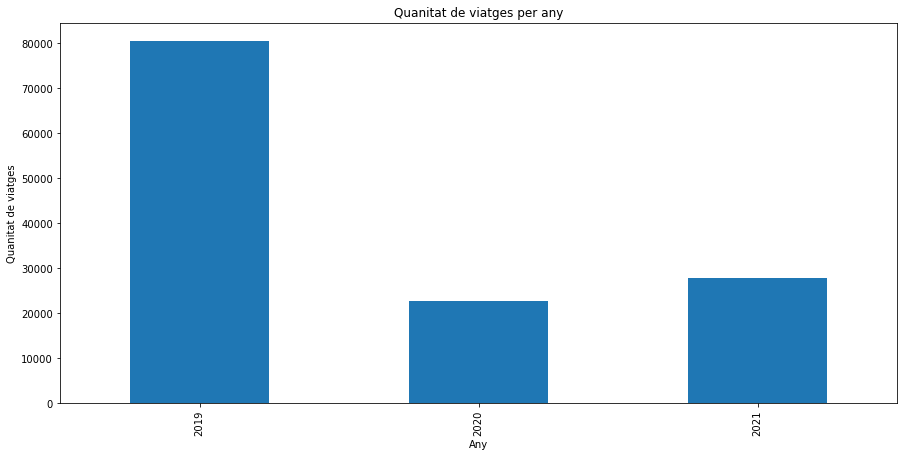

In [25]:
bar_plot(df, 'year', 'Any', 'Quanitat de viatges', 'Quanitat de viatges per any')

**Pregunta: És el comportament que esperàveu? Per què?**

> ANSWER

<font color='CornflowerBlue '>És el comportament esperat. El 2019 el podem entendre com un any de funcionament estàndard. El 2020 arriba la COVID, amb els primers casos a Nova York detectats al principi de març. Durant el març es van començar a prendre mesures com prohibir les aglomeracions, tancar universitats i escoles fins que a principis d'abril es va ordenar el confinament. A partir del juny es va començar a reobrir la ciutat, però lentament. No va ser fins el juny de 2021 que es va acabar l'estat d'emergència, que es va tornar a declarar el novembre per l'ascens de la variant Delta. L'obligació de portar mascareta a certs llocs es va allargar durant tot el 2021.</font>

<font color='CornflowerBlue'>Tenint en compte aquests events, el gràfic mostra el que podem esperar.El 2019, com a últim any amb un comportament sense efectes de la pandèmia, té molts més viatges que el 2020 i 2021. Sabent que el 2020 és quan va esclatar i es van prendre les mesures més restrictives, tampoc és d'estranyar que aquest any fos el més afectat pel virus. Llavors podem veure com el 2021 el nombre de viatges es recupera lleugerament.</font>

<font color='CornflowerBlue'>Aleshores podem entendre el 2019 com un any de control per tenir una idea del volum de viatges amb taxi a la ciutat de Nova York i estudiar l'efecte de la COVID a partir del que passa el 2020, especialment a partir del març, i com l'economia es recupera lentament durant el 2021.</font>

Ara, visualitzarem **quants passatgers hi ha per taxi i per any**.

Crea una figura amb tres subfigures (una per any) on es pugui veure el recompte de passatgers per any.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [26]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm = False):
    '''
    Funció que visualitza quants passatgers hi ha per taxi
    '''
    #Agrupa per any i compta valors. Normalitza segons norm. Passa a frame, el posa en la dimensió desitjada, i fa el plot
    df[['passenger_count', 'year']].groupby(['year']).value_counts(sort=False, normalize=norm)\
        .to_frame().unstack(level=0).plot(kind='bar',   #tipus de plot
                                              subplots=True,  #columnes diferents (anys) en subplots diferents
                                              layout=(1, len(YEARS)),
                                              figsize=(20,5),
                                              legend=False,
                                              title=YEARS,
                                              xlabel=xlabel,
                                              ylabel=ylabel,
                                              ylim=ylim)
    


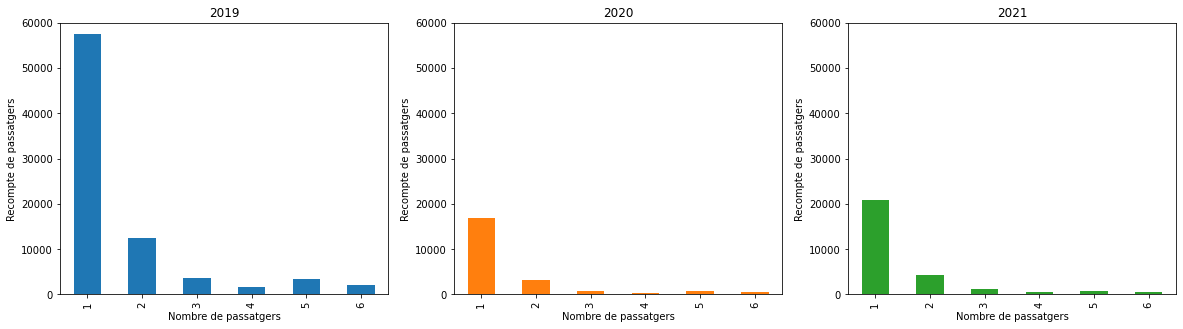

In [27]:
passengers_taxi_year(df, (0, 60000), 'Nombre de passatgers', 'Recompte de passatgers', 'Recompte de passatgers per any')

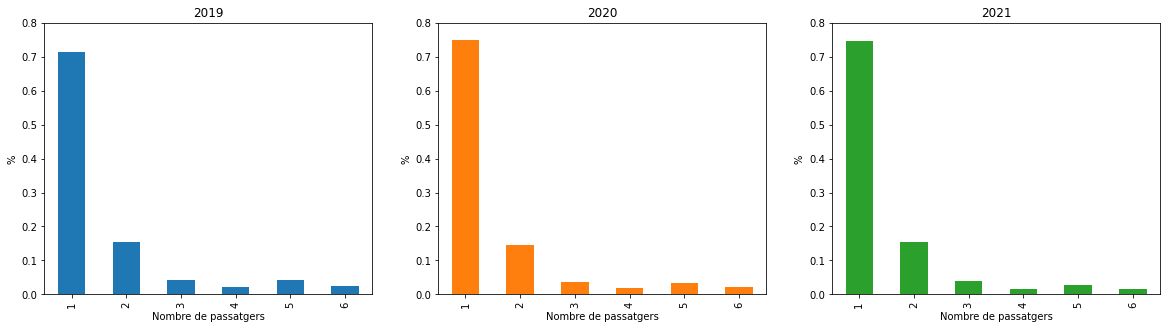

In [28]:
passengers_taxi_year(df, (0, 0.8), 'Nombre de passatgers', '%', '% de passatgers per any', norm = True)

A la figura anterior hem visualitzat cada any per separat. Per tal que la visualització sigui més ràpida i simple d'interpretar, uniu tota la informació en un gràfic.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [29]:
def passengers_taxi(df, xlabel, ylabel, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi
    """
    
    #El dataframe amb les 2 columnes interessants el grupeja per any i compta els valors normalitzant segons norm
    ax = df[['passenger_count', 'year']].groupby(['year']).value_counts(sort=False, normalize=norm).to_frame()\
        .unstack(level=0).plot(kind='bar', title='Nombre de passatgers per taxi') 
    #Mostra el gràfic de línia amb l'estil desitjat a l'axis corresponent

    #Estableix la llegenda i les etiquetes dels eixos
    ax.legend(YEARS)
    ax.set(xlabel=xlabel, ylabel=ylabel)


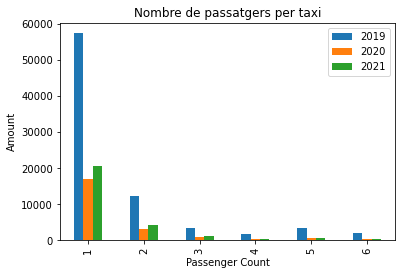

In [30]:
passengers_taxi(df, 'Passenger Count', 'Amount')

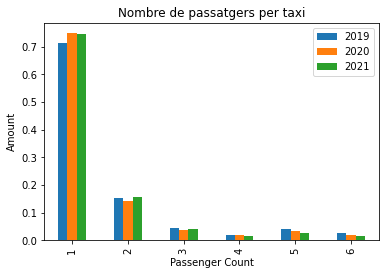

In [31]:
passengers_taxi(df, 'Passenger Count', 'Amount', norm = True)

**Pregunta: Quin impacte heu vist sobre les dades? Creieu que la covid va tenir molt impacte?**

> ANSWER

<font color='CornflowerBlue'>Com és evident, la diferència de viatges totals entre els 3 anys fa que si es mostren les dades sense normalització el que més es veu és justament aquesta diferència. Per això és molt útil veure els gràfics normalitzats, ja que podem veure que la distribució entre el nombre de passatgers es manté molt similar en tots els anys. Potser l'únic que mereix menció és que el 2020 té relativament menys viatges d'una persona que els altres dos anys, i més viatges de 5 i 6 persones especialment. </font>

<font color='CornflowerBlue '>Això pot ser degut a diferents factors. D'una banda, amb la pandèmia segurament es van fer més viatges per necessitat en que un sol passatger l'agafa. A més, al haver-hi menys ocasions socials, menys viatges es devien fer compartint el taxi després d'una menjada o una festa. Tot i això, en els tres anys estudiats, la distribució és clara: els viatges més comuns amb diferència són els d'una persona, seguits per viatges de 2. Finalment, els viatges de més de 2 persones són poc comuns, assolint un mínim a les 4 persones.</font>

<font color='CornflowerBlue '>Per acabar, podem concloure que la COVID no ha tingut un impacte significatiu en la distribució del nombre de passatgers per taxis, doncs ha reduit el nombre de viatges totals, però en general es viatjava amb el mateix nombre de persones per automòvil.</font>

## 03. Quantitat de viatges

Fins ara hem vist la quantitat de viatges que hi ha hagut en els anys estudiats.

Anem a estudiar quins canvis es poden veure si agreguem les dades per hores, dies de la setmana, setmana de l'any i mes.

Aquests gràfics han de ser de línies discontínues i marcar amb una rodona o creu allà on està el valor

In [32]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Funció que visualitza els viatges per diferents agregacions de dades
    """
    #Crea els axis i la figura, i posa el títol
    fig, ax = plt.subplots(1, 2, figsize=(15,6)) #2 columnes: una per pickup i l'altra per dropoff
    fig.suptitle(title)

    #Per cada columna (2 iteracions) mostra un gràfic del nombre de viatges 
    for i in range(len(columns)):
        #Crea una taula on compta el nombre de viatges segons l'any i l'hora de pickup o dropoff segons la columna
        #Mostra el gràfic de línia amb l'estil desitjat a l'axis corresponent
        df.groupby([columns[i]]+['year'])[columns[i]].count().to_frame().unstack().plot(kind='line', ax=ax[i], style='.--') 

        #Estableix la llegenda i les etiquetes dels eixos
        ax[i].legend(YEARS)
        ax[i].set(xlabel=xlabel, ylabel=ylabel)


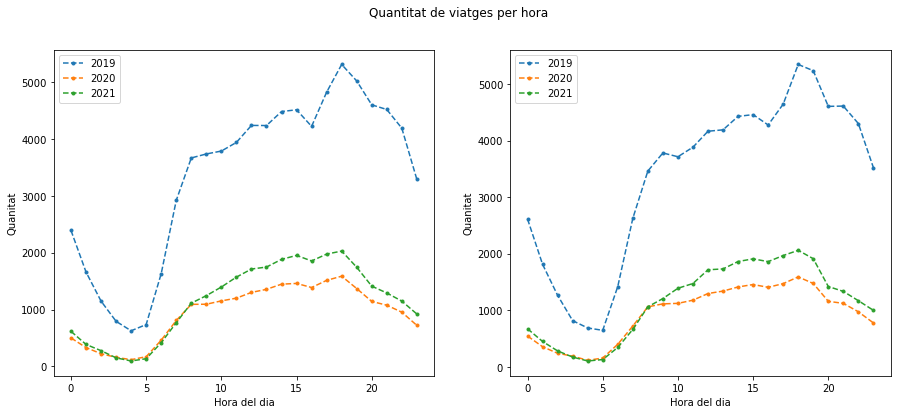

In [33]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title = 'Quantitat de viatges per hora', xlabel = 'Hora del dia', ylabel = 'Quanitat')

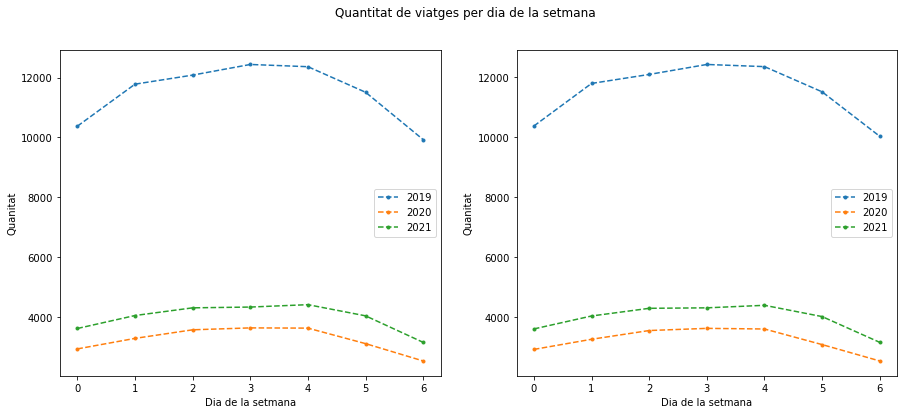

In [34]:
visualize_trips(df, ['pickup_day', 'dropoff_day'], title = 'Quantitat de viatges per dia de la setmana', xlabel = 'Dia de la setmana', ylabel = 'Quanitat')

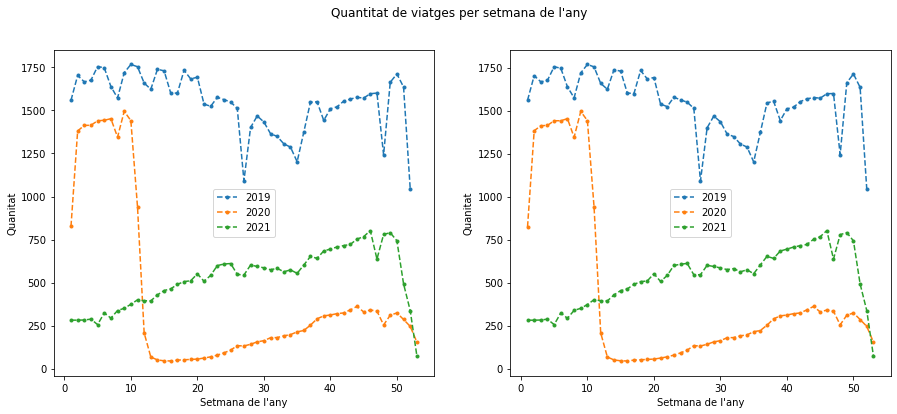

In [35]:
visualize_trips(df, ['pickup_week', 'dropoff_week'], title = 'Quantitat de viatges per setmana de l\'any', xlabel = 'Setmana de l\'any', ylabel = 'Quanitat')

In [36]:
#els anys tenen 52 o 53 setmanes. Google diu 2019 52, 2020 53 i 2021 52, pero aqui 2020 i 2021 tenen 53
df.groupby(['pickup_week']+['year'])['pickup_week'].count().to_frame().unstack().loc[50:]

pickup_week              
year               2019   2020   2021
pickup_week                          
50               1712.0  324.0  743.0
51               1636.0  286.0  493.0
52               1045.0  246.0  338.0
53                  NaN  155.0   75.0

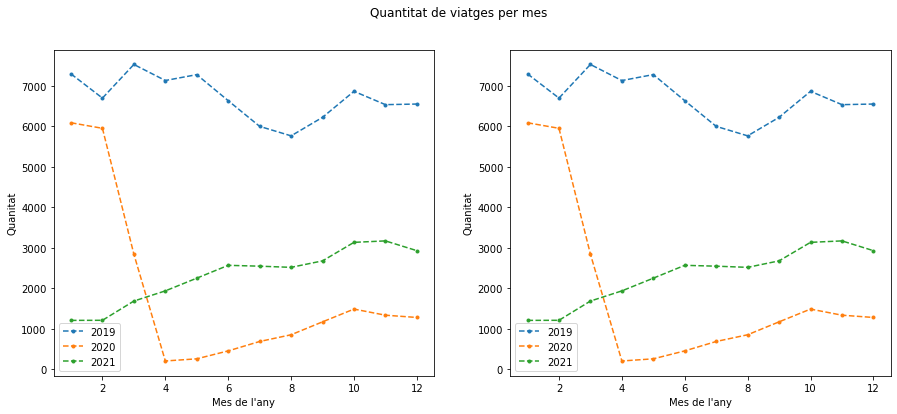

In [37]:
visualize_trips(df, ['pickup_month', 'dropoff_month'], title = 'Quantitat de viatges per mes', xlabel = 'Mes de l\'any', ylabel = 'Quanitat')

**Pregunta: Quins comportaments veieu en cada cas? Quin creieu que és el motiu?**

> ANSWER

##### <font color='darkCyan'> Viatges per hora</font>
<font color='CornflowerBlue '>Es pot observar com a pesar de les diferències en quantitat total de viatges, la tendència és molt similar. Durant la nit, de 12 a 4, baixa dràsticament el nombre de viatges, que puja a partir de les 5 fins arribar al seu màxim al vespre, al voltant de les 6. Un fenòmen curiós és que tot i que el 2021 va haver-hi més viatges que el 2020, el nombre de carreres durant la nit és pràcticament igual i es pot observar la diferència més tard, a partir de les 8.

<font color='CornflowerBlue '>En general, pensem que la COVID no ha afectat en l'hora en què es produeixen els viatges, només en el nombre total. A pesar d'això, sí és cert que el 2019, abans de la pandèmia, el màxim del vespre és més pronunciat que el dels anys 2020 i 2021. Segurament, degut a que molts d'aquests viatges es deuen a gent que torna a casa després de sopar o que surt tard de l'oficina i durant els anys de pandèmia, molta gent treballava des de casa i segurament sortia menys per socialitzar.</font>

##### <font color='darkCyan'> Viatges per dia de la setmana</font>
<font color='CornflowerBlue '>Es veu com els 3 anys tenen mínims el dilluns i diumenge. En tots els casos, hi ha més viatges durant la setmana, especialment divendres. De nou, no sembla que la COVID hagi afectat en la distribució dels viatges, només en la quantitat total.</font>

##### <font color='darkCyan'> Viatges per setmana de l'any i mes</font>
<font color='CornflowerBlue '>A causa de la forta similitud entre aquestes dues mesures, exceptuant la major precisió i soroll que aporta separar els mesos en setmanes, creiem que els resultats és millor comparar-los conjuntament.

<font color='CornflowerBlue '>Es pot veure com l'any 2019 els viatges es mantenen bastant estables, amb una petita depressió durant els mesos d'estiu que comença a recuperar el setembre. Tot i això, es pot observar que els mesos de tardor i l'inici del 2020 tenen menys viatges que l'inici de l'any anterior. El 2020, tot i començar amb certa normalitat, pateix una gran caiguda al març, que es consolida a l'abril. A partir de l'abril, el nombre de viatges augmenta molt lentament, però es queda llunya, durant la resta de l'any, de nivells prèvis a la pandèmia. Igualment, es pot observar una tendència a l'alça durant tot l'any 2021.

<font color='CornflowerBlue '>Si mirem el gràfic per setmanes, podem veure que les tendències es mantenen, tot i que el fet de dividir en intervals de temps més petits fa que aquests siguin més susceptibles a pertorbacions. Es pot observar com durant el 2019 hi ha 3 setmanes amb una gran baixada i com el 2021 el nombre de viatges cau dràsticament les 3 últimes setmanes de l'any. Tot i que alguns d'aquests canvis es poden explicar per festius com Nadal o el 4 de juliol, com que no creiem que tinguin una relació directa amb la COVID, que és el que estem estudiant, ho ignorarem. Tanmateix, cal destacar que no entenem la gran caiguda del final del 2021, per la qual no tenim explicació. Hem provat de graficar-ho amb més dades (canviant el sampling) però es continuava produint aquest fenòmen. Per aquest motiu pensem que no és un problema de les dades que hem samplejat.

## 04. Relació distancia - temps i velocitat

A les dades tenim la distància que ha recorregut el taxi en cada viatge i de la informació temporal podem extreure també la duració d'aquest.


Intentarem esbrinar com la covid va afectar les distàncies i les durades dels viatges juntament amb la velocitat dels taxis.

Creieu que la densitat de trànsit va variar?

### Histogrames

Per començar visualitza els **histogrames** de distància i durada per any.

Pots fer servir la funció *plt.hist()* o *plt.bar()*.

In [120]:

def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Funció que crea un histograma a partir de la informació que conté la columna del dataframe
    """
    
    #Crea figura i afegeix títol
    fig, axs = plt.subplots(1, len(YEARS), figsize=(18,5))
    fig.suptitle(title)
    
    #Per cada any fa un histograma amb la columna corresponent
    for i in range(len(YEARS)):
        #Els histogrames tenen contenidors començant al zero i acabant al límit dret. Hi ha uns 50 contenidors
        axs[i].hist(df.loc[df['year']==YEARS[i],column], bins=range(max(0, xlim[0]),xlim[1],max(((xlim[1])//50),1)))
        axs[i].set(xlabel=xlabel, ylabel=ylabel, xlim=xlim, title=YEARS[i])


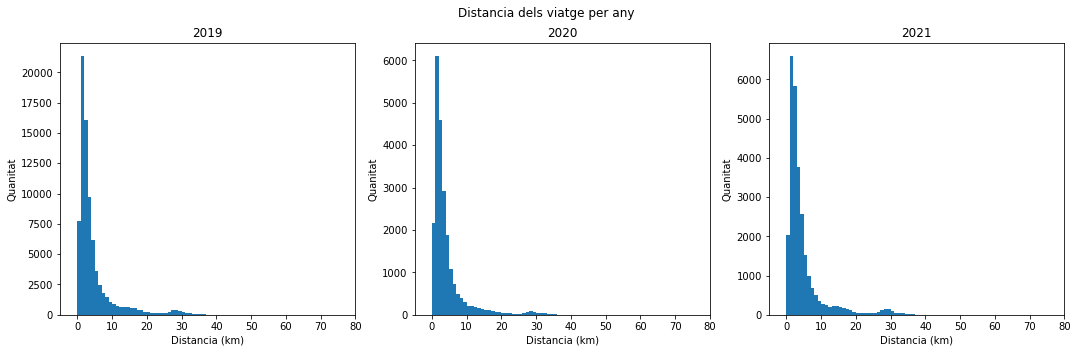

In [121]:
visualize_histograms(df, 'trip_distance', title = 'Distancia dels viatge per any', 
                     xlabel = 'Distancia (km)', ylabel = 'Quanitat', xlim = (-5, 80))
#La mida dels contenidors es d'1 km

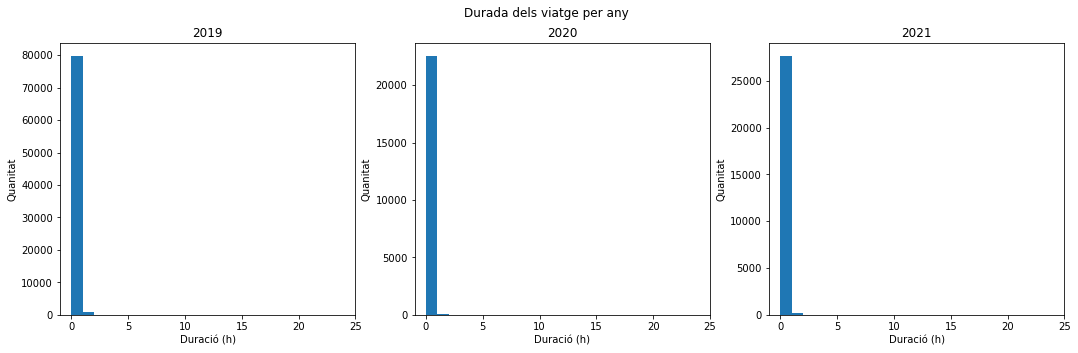

In [122]:
visualize_histograms(df, 'trip_duration', title = 'Durada dels viatge per any', 
                     xlabel = 'Duració (h)', ylabel = 'Quanitat', xlim = (-1, 25) )
#La mida dels contenidors és d'1 hora

**PREGUNTES:** 

* Com creieu que la covid va afectar les distàncies i durades dels viatges?

* I a la velocitat dels taxis?

> ANSWER

### <font color='darkCyan'> Com creieu que la COVID va afectar les distàncies i les durades dels viatges? I la velocitat?</font>
<font color='CornflowerBlue '>Com es pot veure a la primera fila d'histogrames, la distribució de viatges en els tres anys és pràcticament la mateixa. Això ens diu que, a pesar de que va canviar molt el nombre de viatges totals, les distàncies que recorrien els passatgers eren comparables. Aquesta distribució és molt pesada a l'esquerra, amb la majoria de valors en viatges de menys de 5 Km. També es pot apreciar com després va reduint la densitat fins abans dels 30Km, que torna a augmentar.</font>

<font color='CornflowerBlue '>Això es pot explicar pel fet que, a pesar que el 2020 i 2021 van reduir-se molt els viatges, els que es feien segurament eren semblants als realitzats abans de la pandèmia.</font>

<font color='CornflowerBlue '>Pel que fa a les durades dels viatges, passa el mateix.En els 3 casos les distribucions  són pràcticament iguals. Cal destacar,però, que si ens fixem atentament, es pot veure que la proporció de viatges de més d'una hora el 2020 i 2021 és lleugerament menor a la mateixa per l'any 2019. Això, si tenim en compte que, com ja s'ha comentat, les distàncies no varien pràcticament, pot indicar-nos que la durada mitjana s'ha reduit a causa d'un augment de velocitat. Fàcilment es pot justificar pensant que al haver, en general, molts menys viatges de qualsevol tipus, el trànsit era molt menys dens els dos últims anys que el 2019, causant que els mateixos viatges es poguessin realitzar en menys temps.</font>

<font color='CornflowerBlue'>Tanmateix, per estudiar millor la velocitat, ens anirà millor el següent apartat.</font>

### Gràfic de dispersió i correlació

Crea gràfics de dispersió per il·lustrar la relació entre la durada i la distància dels viatges.

Es possible que les dades continguin mostres fora la distribució (outliers). En aquest cas, omet aquestes dades i torna a visualitzar el grafic.

Per veure si existeix alguna correlació, es interesant que utilitzeu la funció *sns.regplot()*.

In [165]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers = False):
    """
    Funció que mostra un scatter plot donades dues dades
    """
    #Segons si cal evitar els outliers, els calcula o no
    if remove_outliers:
        """Considerem outlier aquells viatges per sobre del percentil 99 tant en temps com en distància. No ho considerem
        per sota perquè veient com és la distribució als histogrames anteriors, és clar que la concentració en la part 
        inferior són dades dins del normal, i no outliers."""
        x_max = np.percentile(df[x_value],99)
        y_max = np.percentile(df[y_value],99)
        no_outliers = (df[x_value]<x_max) & (df[y_value]<y_max)
        
        #FacetGrid permet utilitzar regplot separant-ho en anys
        sea = sns.FacetGrid(df.loc[no_outliers], col='year')
    else:
        #Fem el mateix però sense separar els outliers
        sea = sns.FacetGrid(df, col='year')
    
    #Fa regplot segons les columnes 'year' establertes per 'sea', a la x el valor x_value i a la y l'y_value.
    sea.map(sns.regplot, x_value, y_value, line_kws={"color": "red"})#Posa la línia de regressió vermella
    
    #Ajusta les etiquetes, el títol i la mida del layout
    sea.set(xlabel=xlabel, ylabel=ylabel)
    sea.fig.set_size_inches(21, 6)
    sea.fig.suptitle('Relació km/h')
    plt.tight_layout()

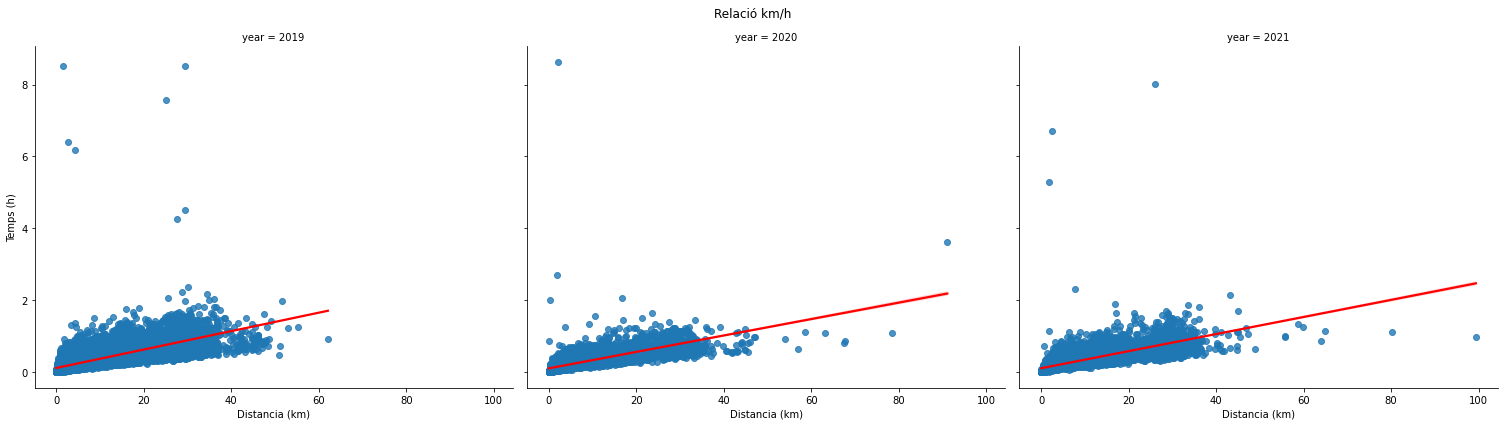

In [166]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)')

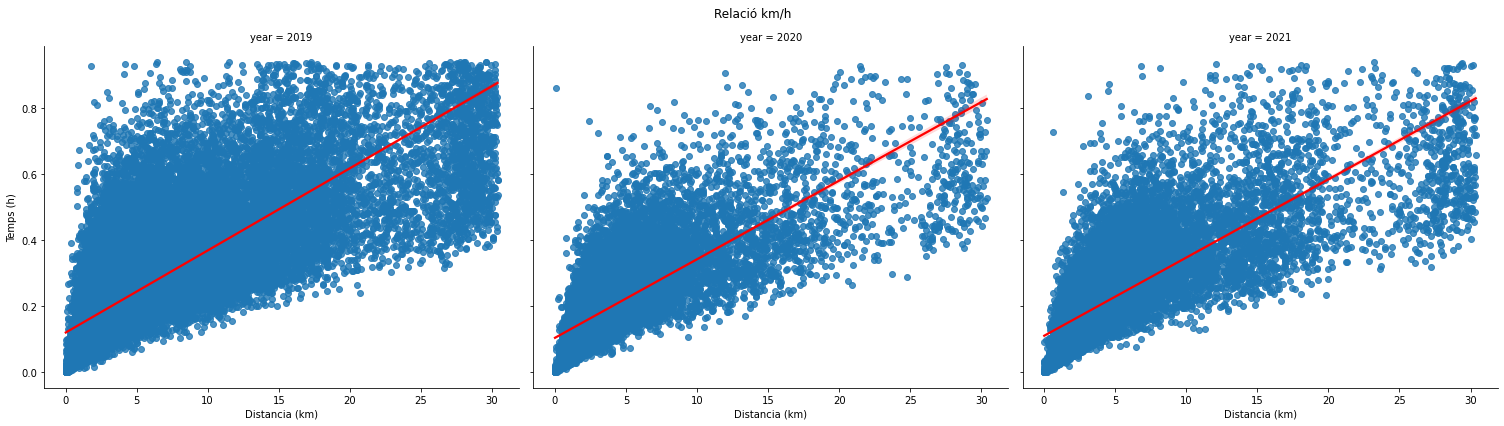

In [167]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)', True)

**Pregunta: Pots veure alguna relació? Pots calcular la correlació entre les dades per treure més informació?**

> ANSWER

<font color='CornflowerBlue'>Una relació que es pot observar entre les dues variables (distància i temps) és bastant òbvia, però val la pena comentar-la: com més llarga la distància, més dura el viatge. Aquesta relació es manté tots els anys, incloent o no els outliers, i en mesures similars en tots els casos.</font>

<font color='CornflowerBlue'>Es pot veure com els punts pels anys 2020 i 2021 són en general més baixos. i.e. els viatges han durat menys en general. Això es reitera pel fet que la pendent de la regressió lineal és lleugerament més gran pel 2019. Això vol dir que aquell any, un viatge de la mateixa durada era, normalment, més llarg que els altres anys. De nou, això té sentit si considerem un nivell de trànsit inferior els anys 2020 i 2021.</font>

<font color='CornflowerBlue'>Excloure els outliers ens és útil perquè podem veure amb més detall la distribució dels punts. En un principi vam pensar de mostrar el gràfic simplement limitant l'eix de  les X i les Y per no incloure els outliers, però llavors la regressió es calcularia incloent-los igualment i creiem que és més interessant veure totes les dades sense els efectes que puguin causar aquestes dades fora del comú.</font>

<font color='CornflowerBlue'>Un dels fenòmens interessants que podem veure un cop eliminem els outliers és el que ja hem observat als histogrames: la densitat de viatges de 20 a 25 Km baixa considerablement, i torna a aumentar prop dels 30 Km. Això es pot deure a que la gent prefereixi altres tipus de transport per aquestes distàncies o que siguin àrees (des del centre) menys poblades. Hem inclós una imatge per donar una idea de la grandària d'un radi de 20 Km a Nova York. Es pot veure com la majoria d'aeroports, atraccions turístiques i zones més densament poblades es troben dins d'aquest radi.</font>
   
<img src="images/new_york_radius.png" width="500">

Tal com fèiem a l'apartat 3, visualitzeu les dades temporals i de distància a partir de les setmanes, i mesos de l'any.

In [181]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Funció que visualitza la distància / duració dels trajectes en un temps a determinar
    """
    #Crea els axis i la figura, i posa el títol
    fig, ax = plt.subplots(1, 2, figsize=(15,6)) #2 columnes: una per pickup i l'altra per dropoff
    fig.suptitle(title)
    
    #Per cada columna (2 iteracions) mostra un gràfic del nombre de viatges 
    for i in range(len(columns)):
        #Crea una taula on calcula la durada/distància mitjana dels viatges segons l'any i l'hora de pickup o dropoff segons la columna
        #Mostra el gràfic de línia amb l'estil desitjat a l'axis corresponent
        df.groupby([columns[i]]+['year'])[column_data].mean().to_frame().unstack().plot(kind='line', ax=ax[i], style='.--') 

        #Estableix la llegenda i les etiquetes dels eixos
        ax[i].legend(YEARS)
        ax[i].set(xlabel=xlabel, ylabel=ylabel)

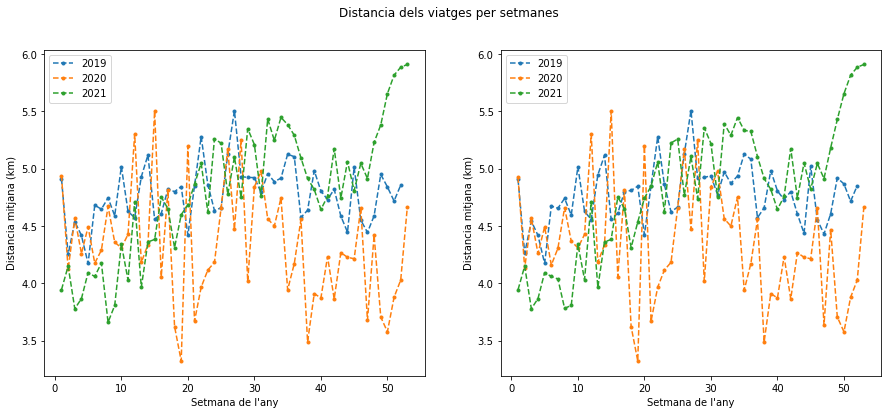

In [182]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Setmana de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per setmanes')

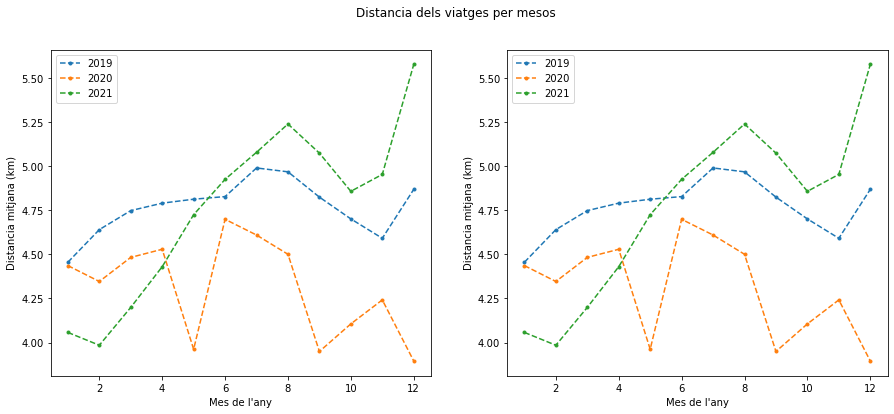

In [183]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per mesos')

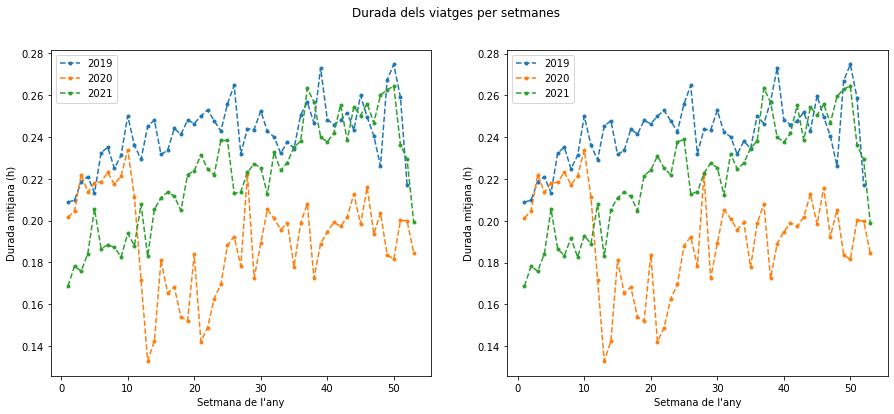

In [184]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Setmana de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per setmanes')

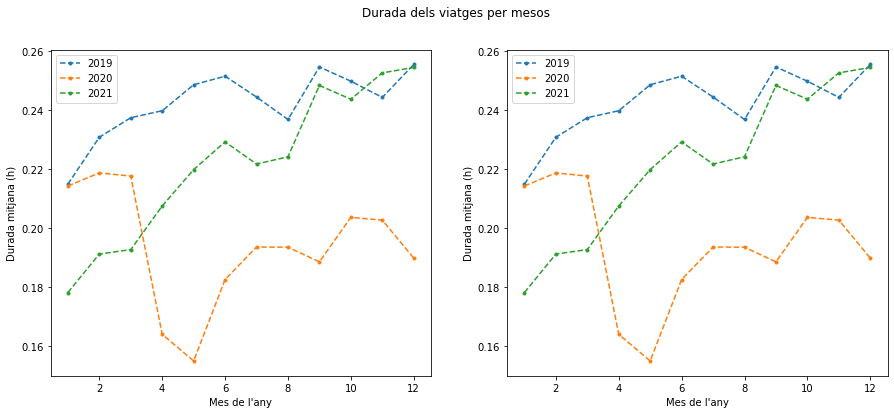

In [185]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per mesos')

**Pregunta: Hi ha algun comportament estrany a part de la covid? Per què pot ser causat?**
    
> ANSWER

<font color='CornflowerBlue'>El gràfic de distància de viatges per setmanes de l'any és molt caòtic i no veiem com extreure'n cap conclusió. El que creiem que val la pena comentar és que es pot veure com, en general, la distància mitjana del 2020 és menor que en la resta d'anys, tret al principi, en setmanes del mig i del final. Això es pot deure a viatges més llargs abans de la pandèmia, durant els mesos d'estiu i abans i després de Nadal. També pensem que és un comportament estrany que les últimes setmanes del 2021 la distància mitjana pugi tant. També hem vist abans que durant aquestes mateixes setmanes el nombre de viatges va baixar molt. Això ens fa pensar que per algun motiu que no hem sabut descobrir els clients preferissin fer pocs viatges més llargs del normal. Tanmateix, el fet que aquelles setmanes hi hagués pocs viatges fa que possibles outliers afectin molt més fortament la mitjana per aquelles setmanes.</font>

<font color='CornflowerBlue'>Pel que fa a la distància per mesos, és fàcil veure com la distància mitjana va caure dràsticamentel maig, el setembre i el desembre de 2020. En general, les distàncies mitjanes pels altres 2 anys segueixen una tendència de creixment fins el juliol o l'agost i llavors cauen fins que tornen a pujar el desembre. Això ho veiem com un comportament normal en què hi ha una depresió al gener doncs potencialment moltes persones comencen l'any volent seguir una vida més activa i decideixen caminar distàncies més llargues, abandonant el propòsit entre febrer i març. Després, amb l'arribada de l'estiu, s'assoleixen els màxims doncs els clients es desplacen a les seves segones residències i els turistes es mouen entre parts més diferenciades de la ciutat que un ciutadà en el seu dia a dia. Finalment per Nadal, segurament moltes persones es desplacen distàncies més llargues per tornar a casa.</font>

<font color='cornflowerBlue'>És curiós com, a pesar de que el confinament es va imposar a l'abril, aquest mes segueix creixent la distància mitjana. Això es pot deure a que aquelles persones que tenen una segona residència prop (com els Hamptons o Connecticut) van decidir anar a passar allí el confinament en lloc de quedar-se a la ciutat. Com que aquells mesos el nombre de viatges va ser molt baix, uns pocs outliers com els descrits poden modificar la mitjana significativament.</font>

<font color='Cornflowerblue'>Respecte la durada mitjana, es pot observar com els anys 2019 i 2021 segueix una tendència similar a la distància. Havent vist la correlació positiva entre les dues, això és lògic. Per això tampoc és d'estranyar que la durada mitjana a partir de l'abril fos menor pel 2020 que pels altres dos anys, exceptuant el principi del 2021. Veiem aquí un clar impacte de la pandèmia, reduint dràsticament la durada mitjana els mesos d'abril i maig de 2020. Això pot ser causat perquè aquests van ser els mesos en què es va imposar el confinament, fent que la gent agafés un taxi només per activitats molt necessàries. Això va causar que els carrers estessin pràcticament deserts i els taxis no trobessin trànsit.</font>

<font color='CornflowerBlue'>També volem destacar que la tendència en alça continuada que s'observa durant tot el 2021 mostra com, a mesura que els carrers es tornaven a omplir, les restriccions l'eliminaven i la vida tornava a la normalitat, la durada dels viatges augmentava. De nou, factors com el trànsit i la tornada als viatges habituals expliquen aquesta situació. </font>



Fins ara hem mostrat les dades de manera agregada.

Per tal de visualitzar-ho de manera global, utilitzarem la funció *plt.imshow()* que visualitza imatges i, per tant, matrius.

Implementa una funció que visualitzi per any:

- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant l'any.
- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant la setmana.

In [50]:
def heatmap(df, group, column_data, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar un mapa de calor
    """
    
    # AQUÍ EL TEU CODI
    fig, ax = plt.subplots(len(YEARS), 1, figsize=(20,6))
    
    for i in range(len(YEARS)):
        matrix = df[df['year']==YEARS[i]].pivot_table(index=group[1],columns=group[0],values=column_data, aggfunc=np.sum, fill_value=0)
        clrmap = ax[i].imshow(matrix)
        ax[i].set_title(YEARS[i])
        ax[i].set(xlabel=xlabel, ylabel=ylabel)
        plt.colorbar(clrmap, ax=ax[i])
        if columns !=None:
            ax[i].set_yticks(range(len(columns)))
            ax[i].set_yticklabels(columns)
    plt.tight_layout() 
    plt.show()
    

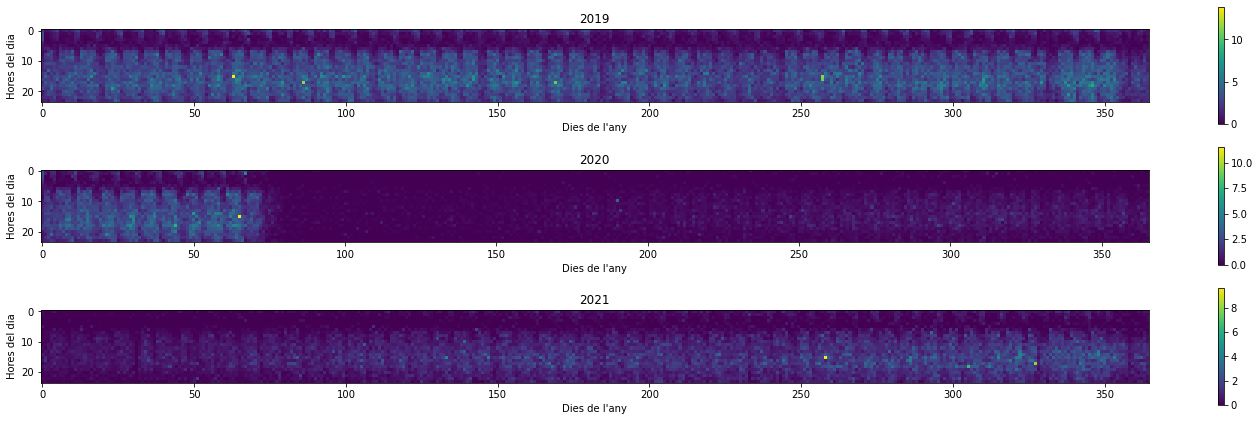

In [51]:
'''DISCLAIMER: hem canviat l\'ordre que ens donava perquè no tenia sentit'''
heatmap(df, ['pickup_dayofyear', 'pickup_hour'], 'trip_duration', 'Dies de l\'any', 'Hores del dia')

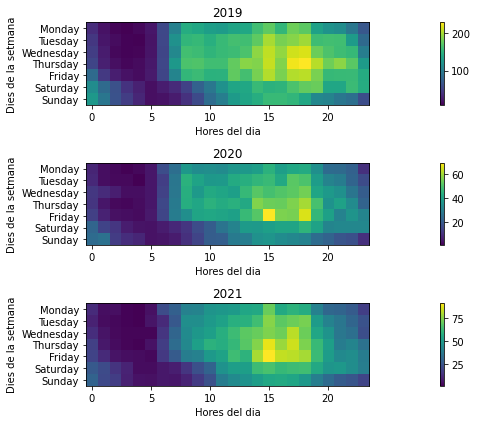

In [52]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_duration', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeteix els gràfics anteriors visualitzant la distancia.

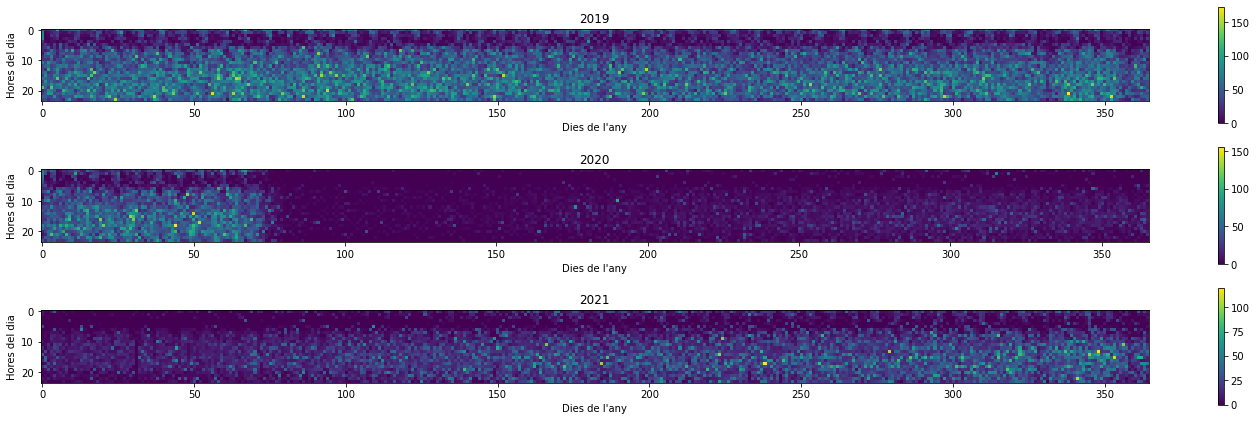

In [53]:
heatmap(df, ['pickup_dayofyear','pickup_hour'], 'trip_distance', 'Dies de l\'any', 'Hores del dia')

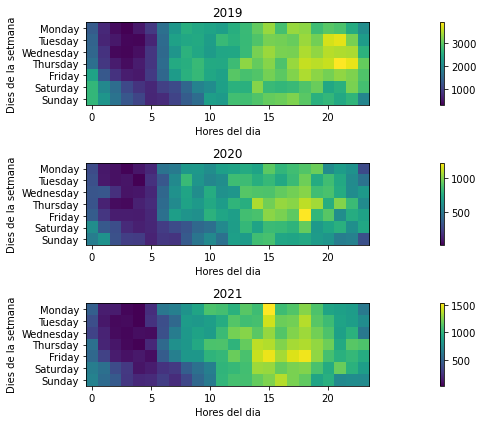

In [54]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_distance', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Per últim, visualitza la velocitat mitjana a les diferents hores del dia durant la setmana.

In [55]:

def speed_heatmap(df, group, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar la velocitat un mapa de calor
    """
    # AQUÍ EL TEU CODI
    fig, ax = plt.subplots(len(YEARS), 1, figsize=(20,6))
    ms_max = df['mean_speed'].max()
    for i in range(len(YEARS)):
        matrix = df[df['year']==YEARS[i]].pivot_table(index=group[1],columns=group[0],values='mean_speed', aggfunc='mean', fill_value=0)
        clrmap = ax[i].imshow(matrix)
        plt.colorbar(clrmap, ax=ax[i])
        ax[i].set_title(YEARS[i])
        ax[i].set(xlabel=xlabel, ylabel=ylabel)
        if columns != None:
            ax[i].set_yticks(range(len(columns)))
            ax[i].set_yticklabels(columns)

    plt.tight_layout() 
    plt.show()

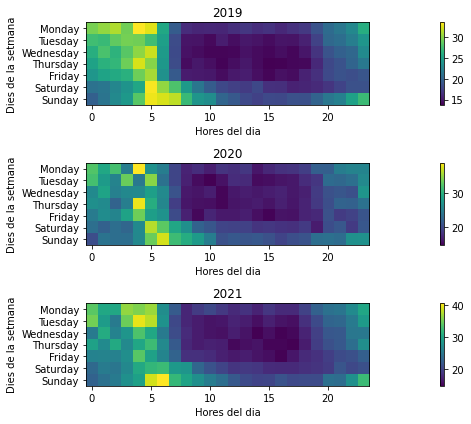

In [56]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Pregunta: Quines conclusions treieu dels mapes de calor?**
    
> ANSWER

## 05. Visualitzem les localitzacions dels viatges

In [57]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,dropoff_hour,pickup_day,dropoff_day,pickup_week,dropoff_week,pickup_month,dropoff_month,trip_duration,pickup_dayofyear,mean_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,2.400,151,239,1,7.0,9.95,2019,...,0,1,1,1,1,1,1,0.111111,1,21.600000
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1,3.056,148,137,2,8.5,9.80,2019,...,1,1,1,1,1,1,1,0.135278,1,22.590554
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1,2.240,249,164,1,7.5,11.40,2019,...,1,1,1,1,1,1,1,0.140833,1,15.905325
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2,1.072,162,137,2,4.0,5.30,2019,...,0,1,1,1,1,1,1,0.050000,1,21.440000
5000,2019-01-01 00:29:00,2019-01-01 00:46:19,1,4.336,161,262,1,13.5,17.76,2019,...,0,1,1,1,1,1,1,0.288611,1,15.023677


Només tenim la ID d'una localització, per tant, necessitem aconseguir la latitud i la longitud.

La mateixa pàgina dels taxis ens dóna el fitxer *taxi_zones.zip*, però primer cal que convertim les dades de coordenades amb format WGS84.

Podem utilitzar aquesta web: https://mygeodata.cloud/

In [58]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [59]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [60]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


In [61]:
#Veiem que els valors son entre 1 i 263 però falten 3 valors: 57, 104 i 105
print(df_loc['LocationID'].unique().shape)
df_loc['LocationID'].unique()

(260,)


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 18

In [62]:
#Comprovem que aquests valors no es trobin en el nostre dataset 
'''DISCLAIMER en la comprehension hi ha 2 for de 3 iteracions només'''
print(any(i in df['PULocationID'] for i in {57, 105, 104}), any(i in df['DOLocationID'] for i in {57, 105, 104}))
#Com que cap d'aquests valors es troba al nostre dataframe, ho ignorem

False False


In [63]:
#Es pot veure que hi ha locationID's repetides. Decidim quedar-nos només amb la primera aparició
df_loc.iloc[54:60]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
54,55,0.149957,0.000736,Coney Island,55,Brooklyn,-73.986212,40.577087
55,56,0.056848,0.000181,Corona,56,Queens,-73.857709,40.741567
55,56,0.056848,0.000181,Corona,56,Queens,-73.853350,40.751981
56,57,0.019271,0.000018,Corona,56,Queens,-73.857709,40.741567
56,57,0.019271,0.000018,Corona,56,Queens,-73.853350,40.751981
57,58,0.059855,0.000205,Country Club,58,Bronx,-73.818971,40.841495


In [64]:
#Borrem duplicats
df_loc = df_loc.drop_duplicates(
    subset='LocationID', #Borrem els que tenen LocationID repetit
    keep='first') #Ens quedem amb la primera aparició
df_loc.iloc[54:60]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
54,55,0.149957,0.000736,Coney Island,55,Brooklyn,-73.986212,40.577087
55,56,0.056848,0.000181,Corona,56,Queens,-73.857709,40.741567
57,58,0.059855,0.000205,Country Club,58,Bronx,-73.818971,40.841495
58,59,0.037795,0.000063,Crotona Park,59,Bronx,-73.893912,40.838935
59,60,0.078648,0.000162,Crotona Park East,60,Bronx,-73.884972,40.831336
60,61,0.117311,0.000511,Crown Heights North,61,Brooklyn,-73.942415,40.673966


D:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


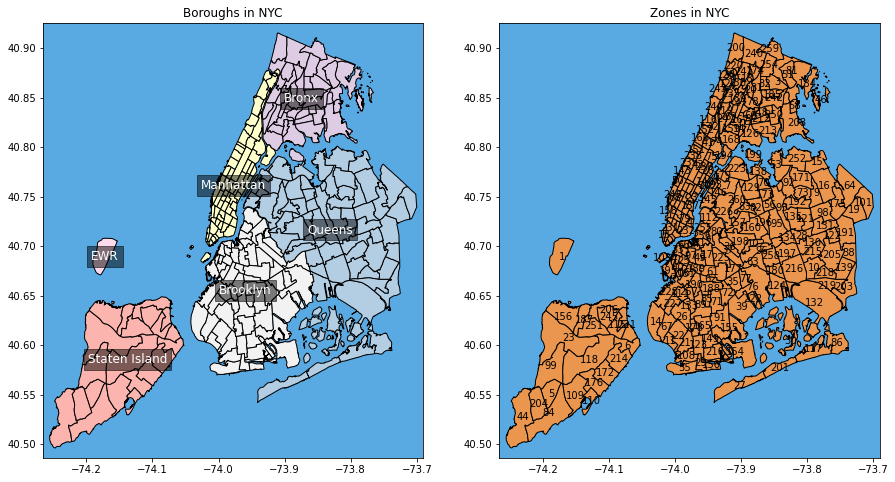

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Ara teniu dos dataframe que necessitem unir. Utilitza la funció *merge* per afegir la longitud i latitud al dataframe *df*:

In [66]:
'''
Afegim 4 columnes al dataframe df: latitud_PU, longitud_PU, latitud_DO i longitud_DO
'''
def merge_locations(df, df_loc, left_on, suffix):
    '''Funció que fa el left merge de dos dataframes segons la clau "left_on" per la dataframe de l`esquerra
    i que afegeix a les noves columnes el sufix "suffix".
    Pren 2 dataframes, i 2 strings com a paràmetres
    Retorna un nou dataframe'''
    
    #Utilitza la funció merge de pandas per fer el left join dels dos dataframes amb la informació que volem
    merge = pd.merge(
        df, df_loc[['LocationID', 'longitude', 'latitude']], #els dos df a unir
        how="left", #tipus de merge
        left_on=left_on, right_on='LocationID') #Les columnes segons les que fem el merge
    
    #Canvia el nom de les columnes afegint un sufix que es passa per paràmetre per diferenciar-les
    merge.rename(columns={'longitude' : 'longitude'+suffix, 'latitude' : 'latitude'+suffix}, inplace = True)
    
    #eliminem la columna de locationID, doncs seria duplicada
    merge.drop('LocationID', axis='columns', inplace=True)
    
    return merge

#Utilitza la funció que hem definit per tal de fer el merge 2 cops. Un per DO i l'altre per PU
merge = merge_locations(
    merge_locations(df, df_loc, 'PULocationID', '_PU'), df_loc, 'DOLocationID', '_DO')
merge.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,dropoff_week,pickup_month,dropoff_month,trip_duration,pickup_dayofyear,mean_speed,longitude_PU,latitude_PU,longitude_DO,latitude_DO
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,2.400,151,239,1,7.0,9.95,2019,...,1,1,1,0.111111,1,21.600000,-73.968222,40.797859,-73.978732,40.784025
1,2019-01-01 00:53:09,2019-01-01 01:01:16,1,3.056,148,137,2,8.5,9.80,2019,...,1,1,1,0.135278,1,22.590554,-73.990664,40.719102,-73.977172,40.740336
2,2019-01-01 00:54:46,2019-01-01 01:03:13,1,2.240,249,164,1,7.5,11.40,2019,...,1,1,1,0.140833,1,15.905325,-74.001965,40.734611,-73.985684,40.749083
3,2019-01-01 00:09:29,2019-01-01 00:12:29,2,1.072,162,137,2,4.0,5.30,2019,...,1,1,1,0.050000,1,21.440000,-73.972471,40.756840,-73.977172,40.740336
4,2019-01-01 00:29:00,2019-01-01 00:46:19,1,4.336,161,262,1,13.5,17.76,2019,...,1,1,1,0.288611,1,15.023677,-73.977680,40.758030,-73.945142,40.776681


In [67]:
#Comprovem que són iguals (les files), aixo vol dir que no hem perdut informació ni duplicat files
print(df.shape, merge.shape)

(130982, 21) (130982, 25)


## 06. ¿Quines zones tenen més recollides i quines zones tenen més entregues?

En aquest apartat volem conèixer i visualitzar les zones on els taxis són més utilitzats.

El primer pas és ordenar i guardar en una variable els llocs més comuns en la recollida i el destí.

Printa els 5 llocs més freqüents per any en cada cas.

In [68]:
# Recollida
# AQUÍ EL TEU CODI
top_pu = merge.groupby(['year','PULocationID']).count().sort_values(['year', 'trip_distance'], ascending = False)['trip_distance'].reset_index()
top_do = merge.groupby(['year', 'DOLocationID']).count().sort_values(['year', 'trip_distance'], ascending = False)['trip_distance'].reset_index()

In [69]:
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    """
    Funció que mostra els llocs més usuals per any
    """
    # AQUÍ EL TEU CODI
    for year in YEARS:
        print(f"Llocs més comuns per {column[:2]} l'any {year}")
        top_locs = df.loc[df['year']==year,column][:n_top].values
        top_locs = df_loc.set_index('LocationID').loc[top_locs].reset_index(inplace=False)
        print(top_locs.loc[:,['LocationID','zone']].to_string(index=False),'\n')


In [70]:
show_top_n(top_pu, 'PULocationID', df_loc)

Llocs més comuns per PU l'any 2019
 LocationID                         zone
        237        Upper East Side South
        161               Midtown Center
        236        Upper East Side North
        162                 Midtown East
        186 Penn Station/Madison Sq West 

Llocs més comuns per PU l'any 2020
 LocationID                         zone
        237        Upper East Side South
        236        Upper East Side North
        161               Midtown Center
        162                 Midtown East
        186 Penn Station/Madison Sq West 

Llocs més comuns per PU l'any 2021
 LocationID                         zone
        237        Upper East Side South
        236        Upper East Side North
        161               Midtown Center
        132                  JFK Airport
        186 Penn Station/Madison Sq West 



In [71]:
show_top_n(top_do, 'DOLocationID', df_loc)

Llocs més comuns per DO l'any 2019
 LocationID                  zone
        236 Upper East Side North
        161        Midtown Center
        237 Upper East Side South
        170           Murray Hill
        162          Midtown East 

Llocs més comuns per DO l'any 2020
 LocationID                  zone
        236 Upper East Side North
        237 Upper East Side South
        161        Midtown Center
        141       Lenox Hill West
        170           Murray Hill 

Llocs més comuns per DO l'any 2021
 LocationID                  zone
        236 Upper East Side North
        237 Upper East Side South
        161        Midtown Center
        170           Murray Hill
        239 Upper West Side South 



**Visualitzem amb un mapa de calor quines són les zones més recurrents**

D:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
D:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
D:\Anaconda\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


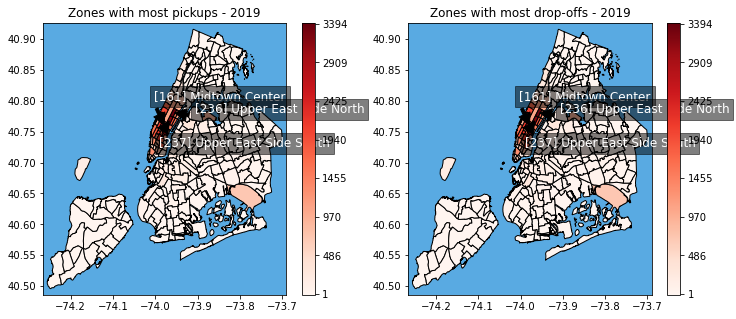

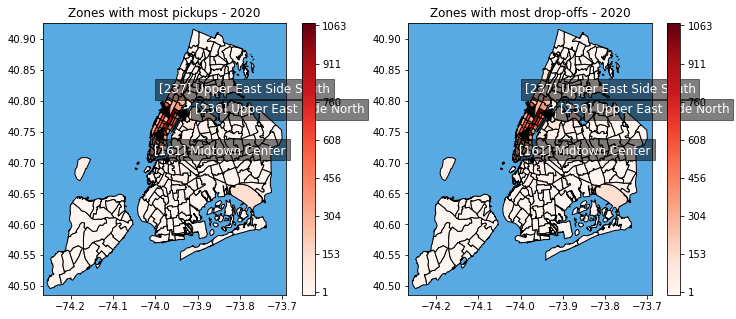

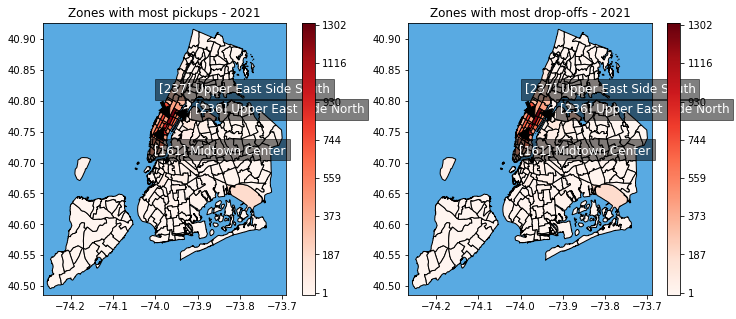

In [72]:
for year in YEARS:
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'trip_distance']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

**Pregunta: Per què creieu que la zona de Manhattan té més quantitat de viatges?**
> ANSWER

## 07. Hospitals

Com ha canviat la destinació dels viatges? Hi ha més gent que va als hospitals?

A la següent cel·la us donem la creació manual d'un DataFrame amb la localització més important dels hospitals de Nova York.

In [73]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077


Utilitza la latitud i longitud de cada hospital i la de les zones del dataframe *merge* per veure la distribució dels hospitals.

Per fer-ho utilitza els gràfics de dispersió. Recorda que s'entendrà millor si els punts són transparents (paràmetre *alpha*).

Després repeteix el mateix gràfic però separat per any. 

<font color='CornflowerBlue '>En aquest apartat hem considerat adient mostrar amb mida</font>

In [74]:
def scatter_locations(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""
    #Crea una figura on hi dubuixa els punts dels coordenades dels hospitals i les de les localitzacions de dropoff (destinacions)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
    data = merge.groupby(['longitude_DO','latitude_DO'])['DOLocationID'].count().reset_index(name='size')
    data['size'] = data['size'].apply(lambda x: x*0.3)
    data.plot(
        x='longitude_DO', 
        y='latitude_DO', 
        kind='scatter', 
        c='cornflowerblue',
        title='Hospitals i entregues de taxis',
        xlabel='Longitude',
        ylabel='Latitude',
        s='size',
        alpha=0.3,
        ax=ax)
    hospitals.plot.scatter(x='Longitude', y='Latitude', alpha=0.5, ax=ax, color='red')
    
    '''x = data['longitude_DO'].reset_index(drop=True)
    print(x.head())
    y = data['latitude_DO'].reset_index(drop=True)
    print(y)
    s = np.array(data['DOLocationID'].count(), dtype='float')
    print(s)
    plt.scatter(x,y,s=s)'''
    '''merge.plot.scatter(x='longitude_DO', y='latitude_DO', alpha=0.1, ax=ax, color='blue')'''


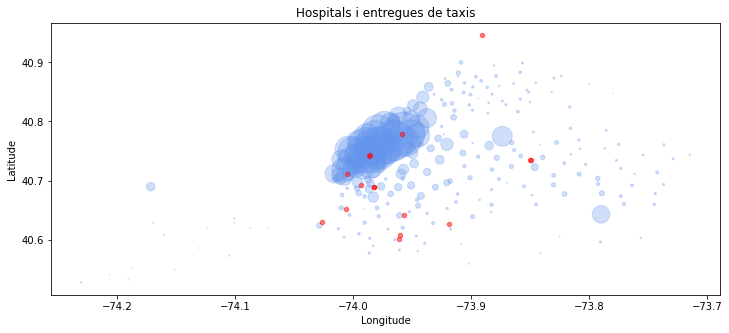

In [75]:
scatter_locations(merge, hospitals)

In [76]:
data = merge.groupby(['longitude_DO','latitude_DO'])['DOLocationID'].count().reset_index(name='size')
data['size'].sum()

130978

In [77]:
def scatter_locations_per_year(merge, hospitals, title='Hospitals i entregues de taxis'):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""
    # Per cada un dels anys que estem estudiant dibuixem un gràfic com l'anterior
    fig = plt.figure(figsize=(10,15))
    for i in range(len(YEARS)):
        ax = fig.add_subplot(len(YEARS),1,i+1)
        data = merge.loc[merge['year']==YEARS[i]].groupby(['longitude_DO','latitude_DO'])['DOLocationID'].count().reset_index(name='size')
        data['size'] = data['size'].apply(lambda x: x*0.5)
        data.plot(
            x='longitude_DO', 
            y='latitude_DO', 
            kind='scatter', 
            c='cornflowerblue',
            title=title,
            xlabel='Longitude',
            ylabel='Latitude',
            s='size',
            alpha=0.3,
            ax=ax)
        hospitals.plot.scatter(x='Longitude', y='Latitude', alpha=0.5, ax=ax, color='red')
        plt.tight_layout()

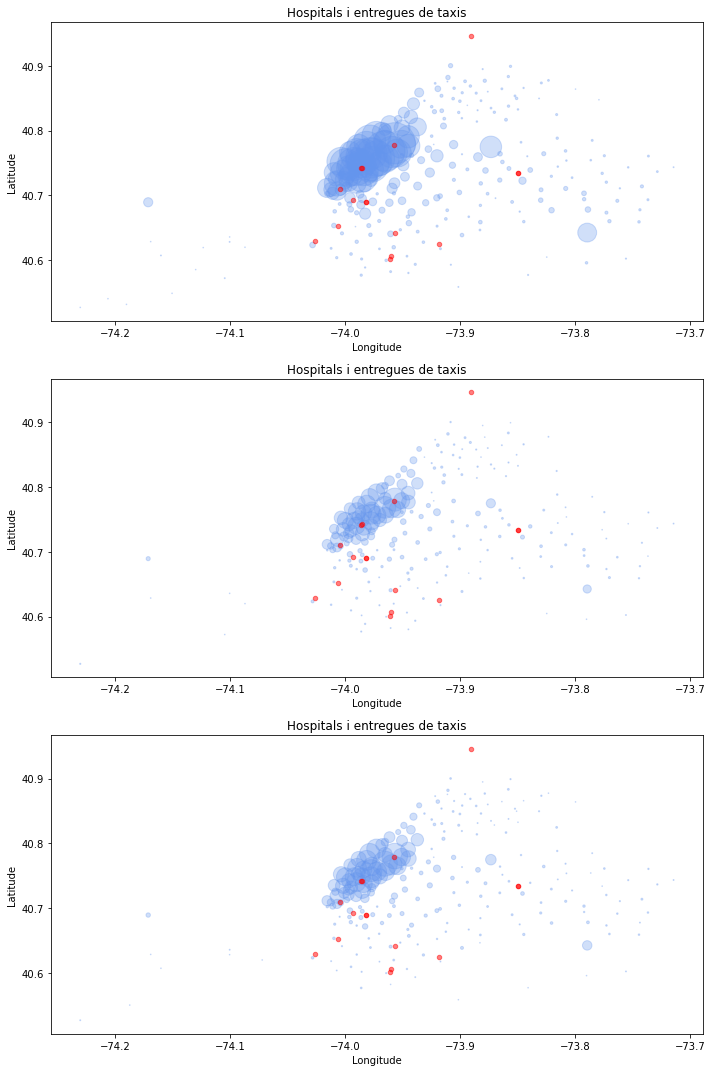

In [78]:
scatter_locations_per_year(merge, hospitals)

**Pregunta: Veus algun comportament?**
>ANSWER

In [79]:
'''Es pot observar com no sembla que hi hagi cap tipus de relació. Com sembla lògic pensar, la gent no agafa el taxi per anar
als hospitals amb una freqüència prou gran com per establir una relació. Tanmateix, es pot tornar a observar com en els anys
de COVID la  distribució de viatges és encara més centrada en Manhattan, havent-hi molts menys viatges a zones menys 
populars de la ciutat.'''

'Es pot observar com no sembla que hi hagi cap tipus de relació. Com sembla lògic pensar, la gent no agafa el taxi per anar\nals hospitals amb una freqüència prou gran com per establir una relació. Tanmateix, es pot tornar a observar com en els anys\nde COVID la  distribució de viatges és encara més centrada en Manhattan, havent-hi molts menys viatges a zones menys \npopulars de la ciutat.'

Per poder conèixer com ha variat els trajectes als hospitals, primer cal detectar a quina localització del mapa pertany cada hospital.

Per fer això cal calcular les distàncies. No calculeu la distància punt a punt, sinó matricialment.

In [80]:
from scipy.spatial import distance_matrix

In [81]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values

# Creem una matriu de distàncies entre la localització dels hospitals i les posicions de destí dels taxis
dist = distance_matrix(hospitals_loc, loc)
dist.shape
print(loc)

[[-74.1715335   40.6894835 ]
 [-73.82247804  40.61082353]
 [-73.84495311  40.8657473 ]
 [-73.97772542  40.72413693]
 [-74.18755828  40.55066406]
 [-74.07256564  40.59904276]
 [-73.92030747  40.76108287]
 [-73.92312156  40.77862509]
 [-73.78651681  40.75434277]
 [-73.78898558  40.67825618]
 [-74.00751041  40.60401449]
 [-74.01572589  40.70249706]
 [-74.01589182  40.71153469]
 [-74.02852137  40.62359276]
 [-73.78527446  40.78488806]
 [-73.77471369  40.76121554]
 [-73.95068947  40.69177696]
 [-73.89127428  40.86867794]
 [-73.72861068  40.73673661]
 [-73.88619043  40.85773934]
 [-73.98585802  40.60199497]
 [-73.99507113  40.60968153]
 [-74.16044164  40.6074501 ]
 [-73.96552238  40.80191569]
 [-73.98647202  40.68571924]
 [-73.99012982  40.62860036]
 [-73.90170527  40.55893992]
 [-73.80832597  40.71074082]
 [-73.96062421  40.58251412]
 [-73.82479985  40.60490931]
 [-73.87610491  40.86001571]
 [-73.86386019  40.86438838]
 [-73.99602169  40.69625694]
 [-73.97231938  40.70250752]
 [-73.91259334

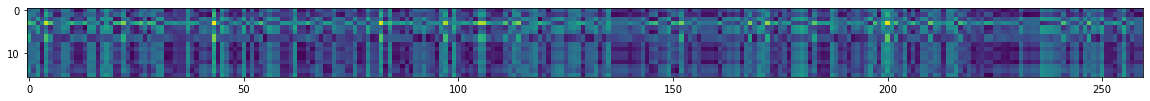

In [82]:
plt.figure(figsize=(20, 5))
plt.imshow(dist)

In [83]:
'''Recordem que a df_loc no hi ha totes les locationID possibles: falten la 57, 104 i 105,
per això la matriu de distàncies només té 260 columens, tot i que LocationID va entre els
valor 1 i 263. Això causa un problema quan mirem a quina zona pertany cada hospital, doncs
no conincideix amb l`index de la columna. Per això creem la següent funció'''
def assign_zones(distance_matrix, df_loc):
    # Prenem com a localització dels hospitals aquell azona que tingui una distància menor amb les coordenades de l'hospital
    hospital_locations = dist.argmin(axis=1) #el argmin a traves de totes les columnes d'aquella fila
    #són els índexs de la matriu, cal convertir a locationID
    return df_loc['LocationID'].unique()[hospital_locations]

Trobeu la manera de localitzar el sector més proper a partir de les distàncies.

In [84]:
# Prenem com a localització dels hospitals aquella zona que tingui una distància menor amb les coordenades de l'hospital
hospitals_locations = dist.argmin(axis=1)
#Afegeix una columna amb la id de localització a la taula dels hospitals
hospitals['LocationID'] = assign_zones(dist, df_loc)

In [85]:
hospitals.head()

,Place Name,Latitude,Longitude,LocationID
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058,209
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092,236
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067,123
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671,200
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077,14


Ara que ja tenim en quin sector es troben els hospitals, visualitzeu quants trajectes hi ha relacionats amb ells.

Suposarem que tots els trajectes al sector van a l'hospital.

Feu una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.

In [86]:
def trips_hospitals(df, hospitals_locations):
    """
    Funció que mostra una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.
    """
    data = merge.loc[merge['year']==YEARS[i]].groupby(['longitude_DO','latitude_DO'])['DOLocationID'].count().reset_index(name='size')
    data['size'] = data['size']
    

In [87]:
trips_hospitals(df, hospitals_locations)

NameError: name 'i' is not defined

## 08. Qui escolta pels forats, sent els seus pecats

A la **primera part** heu de visualitzar i comentar els exemples que hem eliminat, com distancies molt llargues, molt curtes...

A la **segona part** teniu llibertat per escollir i fer visualitzacions que us aportin informació extra que no s'hagi vist anteriorment.

In [ ]:
'''
Viatges als aeroports
relacio distancia/preu
payment type
'''

### Viatges als aeroports
En aquest apartat continuem estudiant si ha canviat la destinació dels passatgers. En concret, mirarem si els viatges a l'aeroport han disminuit en relació a la resta de viatges.

In [ ]:
#Aeroporst de la ciutat de Nova York
airports = [('John F. Kennedy International Airport', 'JFK', '40.641766', '-73.780968'),
('Newark Liberty International Airport', 'EWR', '40.689531', '-74.174462'),
('LaGuardia Airport', 'LGA', '40.776927', '-73.873966'),]

#Aquests són aeroports que donen servei a l'àrea metropolitana, que no hem usat per estar molt lluny
not_used = [('Westchester County Airport', 'HPN', '41.068333', '-73.708664'),
           ('Stewart International Airport', 'SWF', '41.498403', '-74.100863'),
           ('Long Island MacArthur Airport', 'ISP', '40.789845', '-73.097568'),
           ('Trenton–Mercer Airport', 'TTN', '40.276999', '-74.817951'),]

#Crea el dataframe amb els aeroports
airports = pd.DataFrame(airports, columns = ['Place Name', 'IATA', 'Latitude', 'Longitude'])
airports['Latitude'] = airports['Latitude'].astype(float)
airports['Longitude'] = airports['Longitude'].astype(float)

#Utilitzem la funció que ja hem definit pels hospitals per fer un scatter de dropoff i aeroports
scatter_locations_per_year(merge, airports, "Aeroports i entregues de taxis")

In [ ]:
airports = airports.drop_duplicates(subset='IATA', keep='first')
airports.head(7)

### Relació distància/preu
En aquest apartat, volem respondre si el fet de reduir el nombre de viatges que els taxistes feien de manera dràstica va causar un canvi en les seves tarifes. 

### Tipus de pagament
En aquest apartat estudiarem si la COVID va causar un canvi en la preferència de tipus de pagament. Els passatgers han començat a pagar més amb targeta?

In [ ]:
df.index

In [ ]:
def stacked_bar(df, column, title):
    df.pivot_table(df, values='payment_type', index=['year'], columns=['payment_type'], aggfunc='count').plot.bar(stacked=True)
    #print(df.groupby(['year', 'payment_type']).value_counts())

In [ ]:
stacked_bar(df, 'payment_type', 'Tipus de pagament')

## 09. Informe

A partir de l'exploració de les dades que heu fet al llarg d'aquest notebook, feu un petit informe resumint i justificant tots els canvis que han sorgit a causa de la covid.